# Open Source Energy System Modeling¶
## Assignment for 2019/05/28 by Johannes Radl radl@eeg.tuwien.ac.at

For a better overview I have deleted the previous explainatory text fields.

## Setup

First, we import all the packages we need.

In [1]:
from __future__ import division # makes division work the same way between py2 and py3

In [2]:
import pandas as pd
import ixmp as ix
import message_ix

from message_ix.utils import make_df
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

The `Platform` is your connection to a database

In [3]:
mp = ix.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at 'C:\Users\jradl\.local\ixmp\localdb\default'


Once connected, we make our `Scenario` which we use to build our model.

In [4]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scenario='baseline', version='new') #Deleting ", version='new'" gives error in next line

In [5]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon({'year': history + model_horizon,  
                      'firstmodelyear': model_horizon[0]})

In [6]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

In [7]:
scenario.add_set("commodity", ["electricity", "light"])

scenario.add_set("level", ["secondary", "final", "useful"])

scenario.add_set("technology", ['coal_ppl', 'wind_ppl', 'grid', 'bulb', 'LED'])

scenario.add_set("mode", "standard")

## Supply and Demand (or Balancing Commodities)

The fundamental premise of the model is to satisfy demand. To first order, demand for services like electricity track with economic productivity (GDP). We define a GDP profile similar to first-world GDP growth from [1900-1930](https://en.wikipedia.org/wiki/List_of_regions_by_past_GDP):

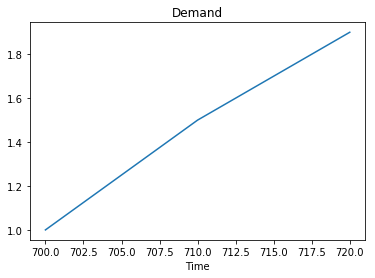

In [8]:
gdp_profile = pd.Series([1., 1.5, 1.9], 
                        index=pd.Index(model_horizon, name='Time'))
gdp_profile.plot(title='Demand')

Note present day: [~17000 GWh in Austria](http://www.iea.org/statistics/statisticssearch/report/?country=AUSTRIA&product=electricityandheat&year=2015) with population [~9M](http://www.austria.org/population/) which is ~1890 kWh per capita

In [9]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': model_horizon,
        'time': 'year',
        'value': (100 * gdp_profile).round(),
        'unit': 'GWa',
    })

In [10]:
scenario.add_par("demand", light_demand)

In [11]:
#TODO Hide this one

year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base_input = {
    'node_loc': country,
    'year_vtg': vintage_years
    ,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}

base_output = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_dest': country,
    'time': 'year',
    'time_dest': 'year', 
    'unit': '%',
}

Working backwards along the Reference Energy System, we can add connections for the `bulb` and 'LED'

In [12]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=1.0)
scenario.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
                  level='final', value=1.0, unit='%')
scenario.add_par('input', bulb_in)

LED_out = make_df(base_output, technology='LED', commodity='light', 
                   level='useful', value=1.0)
scenario.add_par('output', LED_out)

LED_in = make_df(base_input, technology='LED', commodity='electricity',  
                  level='final', value=0.75, unit='%')
scenario.add_par('input', LED_in)

Next, the `grid`, with loses of 13%

In [13]:
grid_efficiency = 1
grid_out = make_df(base_output, technology='grid', commodity='electricity', 
                   level='final', value=grid_efficiency)
scenario.add_par('output', grid_out)

grid_in = make_df(base_input, technology='grid', commodity='electricity',
                  level='secondary', value=1.0, unit='%')
scenario.add_par('input', grid_in)

And finally, our power plants. The model does not include the fossil resources used as `input` for coal plants; however, costs of coal extraction are included in the parameter $variable\_cost$.

In [14]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', coal_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', wind_out)

## Operational Constraints and Parameters

The model has a number of "reality" constraints, which relate built capacity to available power.

The `CAPACITY_CONSTRAINT` 

$\sum_{m} ACT_{n,t,y^V,y,m,h}
    \leq duration\_time_{h} \cdot capacity\_factor_{n,t,y^V,y,h} \cdot CAP_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$


This requires us to provide capacity factors

In [15]:
#TODO: Hide this
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '%',
}

In [16]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 1,
    'bulb':1,
    'LED':1,
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

The model can further be provided `technical_lifetime`s in order to properly manage deployed capacity and related costs via the `CAPACITY_MAINTENENCE` constraint:

$CAP_{n,t,y^V,y} \leq remaining\_capacity_{n,t,y^V,y} \cdot value \: \: \forall t \in T^{INV}$

Where `value` can take different forms depending on what time period is considered:

| Value                                 | Condition                                                      |
|---------------------------------------|----------------------------------------------------------------|
| $\Delta_y historical\_new\_capacity_{n,t,y^V}$ | $y$ is first model period                                      |
| $\Delta_y CAP\_NEW_{n,t,y^V}$                  | $y = y^V$                                                      |
| $CAP_{n,t,y^V,y-1}$                   | if $y > y^V$ and $y - y^V < technical\_lifetime_{n,t,y^V}$     |


In [17]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [18]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'bulb': 1,
    'LED': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

## Technological Diffusion and Contraction

We know from historical precedent that energy systems can not be transformed instantaneously. Therefore, we use a family of constraints on **activity** (`ACT`) and **capacity** (`CAP`). 

$\sum_{y^V \leq y,m} ACT_{n,t,y^V,y,m,h} \leq$  
$initial\_activity\_up_{n,t,y,h}
        \cdot \frac{ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} - 1 }
                   { growth\_activity\_up_{n,t,y,h} }+ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} \cdot \Big( \sum_{y^V \leq y-1,m} ACT_{n,t,y^V,y-1,m,h} + \sum_{m} historical\_activity_{n,t,y-1,m,h}\Big)$  

This example limits the ability for technologies to **grow**. To do so, we  need to provide `growth_activity_up` values for each technology that we want to model as being diffusion constrained. Here, we set this constraint at 5% per year.

In [19]:
## TODO: hide this
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '%',
}

In [20]:
growth_technologies = [
    "coal_ppl", 
    "wind_ppl", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0) 
    scenario.add_par('growth_activity_up', df)



## Introducing a diffuision rate for LED

In [21]:
df = make_df(base_growth, technology="LED", value=0)     
scenario.add_par('growth_activity_up', df)

## Defining an Energy Mix

To model the transition of an energy system, one must start with the existing system which are defined by the parameters `historical_activity` and `historical_capacity`. These parameters define the energy mix before the model horizon.  

We begin by defining a few key values:

- how much useful energy was needed
- how much final energy was generated
- and the mix for different technologies

In [22]:
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.6

In [23]:
# TODO: hide

base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}


Then, we can define the **activity** and **capacity** in the historic period

In [24]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': (1 - coal_fraction) * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('historical_activity', df)

In [25]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

## Objective Function

The objective function drives the purpose of the optimization. Do we wish to seek maximum utility of the social planner, minimize carbon emissions, or something else? Classical IAMs seek to minimize total discounted system cost over space and time. 

$\min \sum_{n,y \in Y^{M}} interestrate_{y} \cdot COST\_NODAL_{n,y}$


First, let's add the interest rate parameter.

In [26]:
rate = [0.05] * len(model_horizon)
unit = ['%'] * len(model_horizon)
scenario.add_par("interestrate", key=model_horizon, val=rate, unit=unit)

`COST_NODAL` is comprised of a variety of costs related to the use of different technologies.

### Investment Costs

Capital, or investment, costs are invoked whenever a new plant or unit is built

$inv\_cost_{n,t,y} \cdot construction\_time\_factor_{n,t,y} \cdot CAP\_NEW_{n,t,y}$

In [27]:
# TODO hide this
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/GWa',
}

In [28]:
# in $ / kW
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'bulb': 5,
    'LED':50,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

### Fixed O&M Costs

Fixed cost are only relevant as long as the capacity is active. This formulation allows to include the potential cost savings from early retirement of installed capacity.

$\sum_{y^V \leq y} \ fix\_cost_{n,t,y^V,y} \cdot CAP_{n,t,y^V,y}$

In [29]:
# TODO Hide
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/GWa',
}


In [30]:
# in $ / kW
costs = {
    'coal_ppl': 30,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

### Variable O&M Costs

Variable Operation and Maintence costs are associated with the costs of actively running the plant. Thus, they are not applied if a plant is on standby (i.e., constructed, but not currently in use).

$\sum_{\substack{y^V \leq y \\ m,h}} \ var\_cost_{n,t,y^V,y,m,h} \cdot ACT_{n,t,y^V,y,m,h} $

In [31]:
# TODO hide
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/GWa',
}

In [32]:
# in $ / MWh
costs = {
    'coal_ppl': 30,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scenario.add_par('var_cost', df)

A full model will also have costs associated with

- resource extraction: $\sum_{c,g} \ resource\_cost_{n,c,g,y} \cdot EXT_{n,c,g,y} $
- emissions (TODO recopy this, hats no good): $\sum_{e,t, e \in E(e)} emission\_scaling_{e,e} \cdot \ emission\_tax_{n,e,t,y} \cdot EMISS_{n,e,t,y}$
- land use (emulator): $\sum_{s} land\_cost_{n,s,y} \cdot LAND_{n,s,y}$
- exceedence on "hard" bounds of technology expansion and contraction: $\sum_{m,h} \ \Big( abs\_cost\_activity\_soft\_lo_{n,t,y,m,h} + level\_cost\_activity\_soft\_lo_{n,t,y,m,h} \cdot\ levelized\_cost_{n,t,y,m,h}\Big) \cdot ACT\_LO_{n,t,y,h}$

## Time to Solve the Model

In [33]:
scenario.commit(comment='basic model of Westerosi electrification')
scenario.set_as_default()

In [34]:
scenario.solve()

CalledProcessError: Command 'gams "C:\Users\jradl\Anaconda3\lib\site-packages\message_ix\model\MESSAGE_run.gms" --in="C:\Users\jradl\Anaconda3\lib\site-packages\message_ix\model\data\MsgData_Westeros_Electrified_baseline.gdx" --out="C:\Users\jradl\Anaconda3\lib\site-packages\message_ix\model\output\MsgOutput_Westeros_Electrified_baseline.gdx" --iter="C:\Users\jradl\Anaconda3\lib\site-packages\message_ix\model\output\MsgIterationReport_Westeros_Electrified_baseline.gdx" LogOption=4' returned non-zero exit status 3.

In [ ]:
scenario.var('OBJ')['lvl']

# Plotting Results

In [ ]:
from tools import Plots
p = Plots(scenario, country, firstyear=model_horizon[0])

# Activity

How much energy is generated in each time period from the different potential sources?

In [ ]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])
#plt.savefig('bsl_LED_1.png')

In [ ]:
scenario.equ_list()

## Capacity

Given how many new plants are built, how many are actually used?

In [ ]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])
#plt.savefig('bsl_LED_2.png')

In [ ]:
p.plot_capacity(baseyear=True, subset=['bulb', 'LED'])


## Electricity Price

And how much does the electricity cost? These prices are taken from the **dual variables** of the solution and are given the name **shadow prices**. They reflect the marginal price of electricity, taken from the most expensive producer.  

Note that the price drop when the most expensive technology is no longer in the system.

In [ ]:
p.plot_prices(subset=['light'], baseyear=True)
#plt.savefig('bsl_LED_3.png')

In [ ]:
#scenario.to_excel('baseline_new.xlsx')


# Comparing the LED result with the bulbs-only result
When we compare the results with the bulbs-only scenario we see no change in activity, capacity nor electricity price.

In [ ]:
p.plot_capacity(baseyear=True, subset=['bulb', 'LED'])

In [ ]:
#img=mpimg.imread('bsl_1.png')
#imgplot = plt.imshow(img)

In [ ]:
#img=mpimg.imread('bsl_LED_1.png')
#imgplot = plt.imshow(img)

In [ ]:
#img=mpimg.imread('bsl_2.png')
#imgplot = plt.imshow(img)

In [ ]:
#img=mpimg.imread('bsl_LED_2.png')
#imgplot = plt.imshow(img)

In [ ]:
#img=mpimg.imread('bsl_3.png')
#imgplot = plt.imshow(img)

In [ ]:
#img=mpimg.imread('bsl_LED_3.png')
#imgplot = plt.imshow(img)

# Fin

With that, you have built and run your very first MESSAGEix model. Welcome to the community!

Check us out on Github: https://github.com/iiasa/message_ix  

Get in touch with us online: https://groups.google.com/forum/message-ix  

And feel free to contact me with any further questions: gidden@iiasa.ac.at

In [ ]:
mp.close_db()